<a href="https://colab.research.google.com/github/MittalMonika/DataScience/blob/master/PredictPrice_JP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#!cd /content/drive/MyDrive/QuantAnalyis/

Mounted at /content/drive


In [48]:
from matplotlib import dates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
plt.rcParams['figure.figsize'] = [5, 3]

# Task 3: Credit risk analysis

 Use the data at "/content/drive/MyDrive/QuantAnalyis/InputDir/Task 3 and 4_Loan_Data.csv" to build a model that, given details for any loan with each row providing details of the borrower, including their income, total loans outstanding, and a few other metrics. There is also a column indicating if the borrower has previously defaulted on a loan. Predict the probability that the borrower will default (also known as PD: the probability of default). Use the provided data to train a function that will estimate the probability of default for a borrower. Assuming a recovery rate of 10%, this can be used to give the expected loss on a loan.

You should produce a function that can take in the properties of a loan and output the expected loss.
You can explore any technique ranging from a simple regression or a decision tree to something more advanced. You can also use multiple methods and provide a comparative analysis.



In [50]:
df = pd.read_csv("/content/drive/MyDrive/QuantAnalyis/InputDir/Task 3 and 4_Loan_Data.csv")
#df



# Exploratory Data Analysis (EDA) for Loan Default Dataset

Before diving into the model building, EDA is a critical step.

The Given dataset is a combination of numerical and binary features (default--> 0,1). Let's explore various aspects:

### Understanding Variables:
Identify the target variable: default

Identify feature variables: credit_lines_outstanding, loan_amt_outstanding, total_debt_outstanding, income, years_employed, fico_score.

### Univariate Analysis:
For Numerical Variables :
   > Describe statistics, histograms, boxplots

For Categorical/Binary Variables: Count plots.

In [ ]:
# Summary statistics
df.describe()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.974577e+06,1.461200,4159.677034,8718.916797,70039.901401,4.552800,637.557700,0.185100
std,2.293890e+06,1.743846,1421.399078,6627.164762,20072.214143,1.566862,60.657906,0.388398
min,1.000324e+06,0.000000,46.783973,31.652732,1000.000000,0.000000,408.000000,0.000000
25%,2.977661e+06,0.000000,3154.235371,4199.836020,56539.867903,3.000000,597.000000,0.000000
50%,4.989502e+06,1.000000,4052.377228,6732.407217,70085.826330,5.000000,638.000000,0.000000
75%,6.967210e+06,2.000000,5052.898103,11272.263740,83429.166133,6.000000,679.000000,0.000000
max,8.999789e+06,5.000000,10750.677810,43688.784100,148412.180500,10.000000,850.000000,1.000000


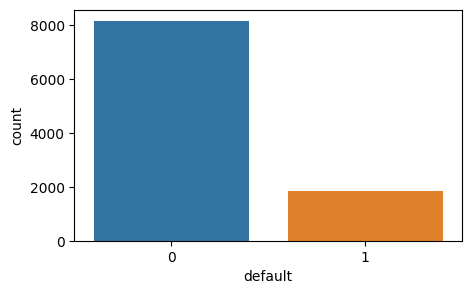

In [51]:
# Distribution of target variable
sns.countplot(x='default', data=df)
plt.show()

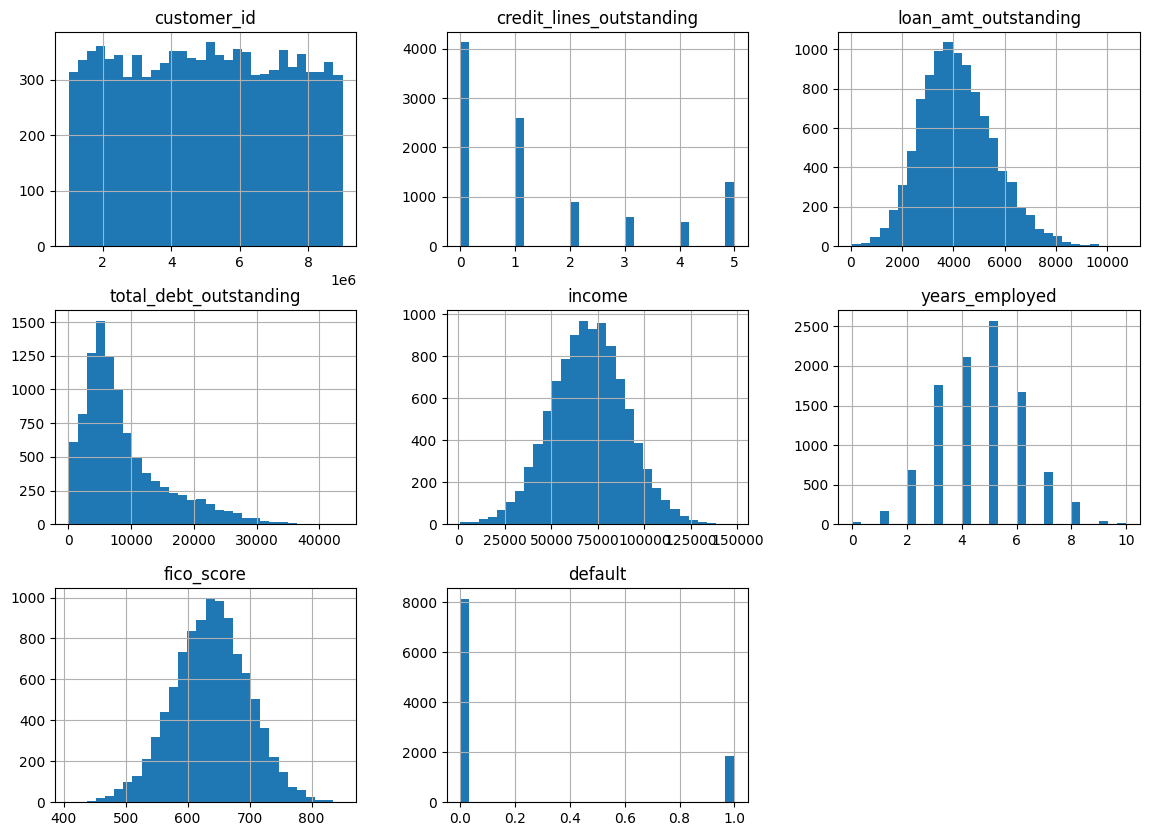

In [52]:
#Distribution of numerical variables
df.hist(bins=30, figsize=(14,10))
plt.show()

### Bivariate Analysis:
Numeric vs. Target Variable:
> Boxplots for each numeric variable vs. default

Correlation Matrix:
>To check multicollinearity and understand the relationship between different numeric variables.

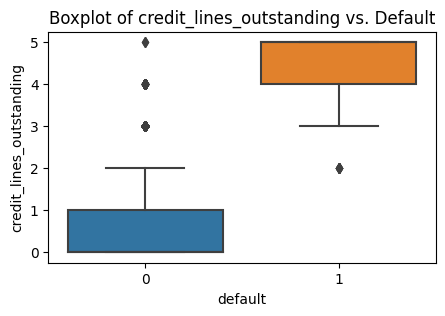

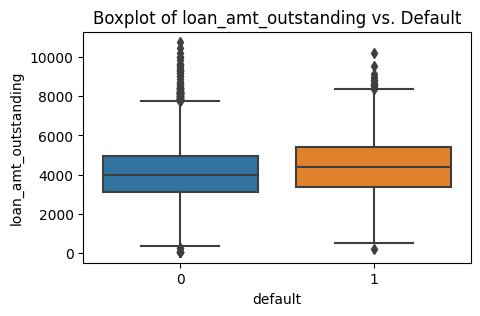

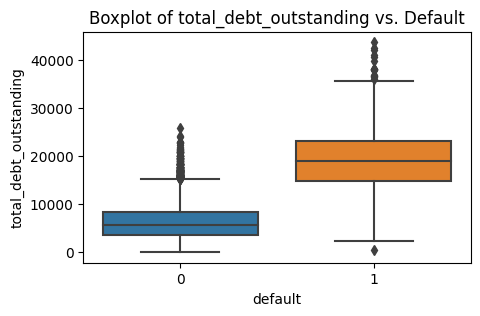

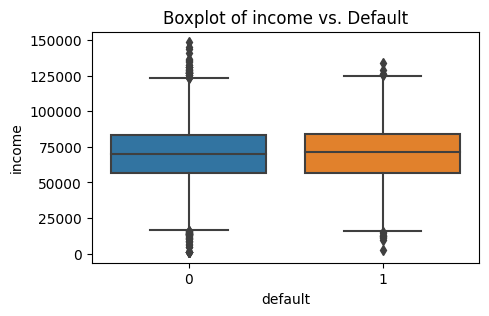

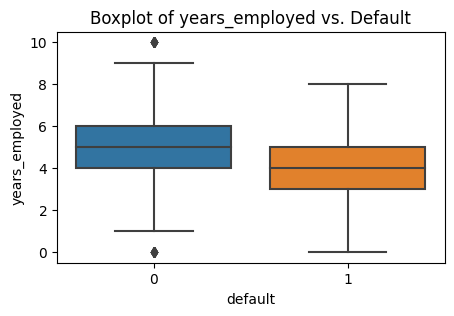

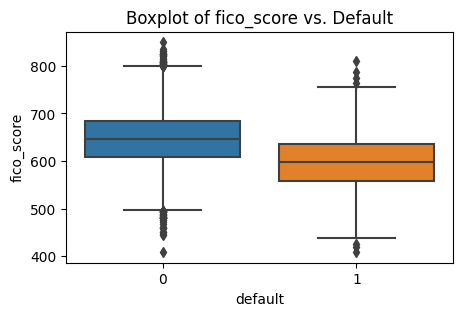

In [53]:
#Boxplots for numerical variables vs. default
num_vars = ['credit_lines_outstanding', 'loan_amt_outstanding', 'total_debt_outstanding', 'income', 'years_employed', 'fico_score']
for var in num_vars:
    sns.boxplot(x='default', y=var, data=df)
    plt.title(f'Boxplot of {var} vs. Default')
    plt.show()

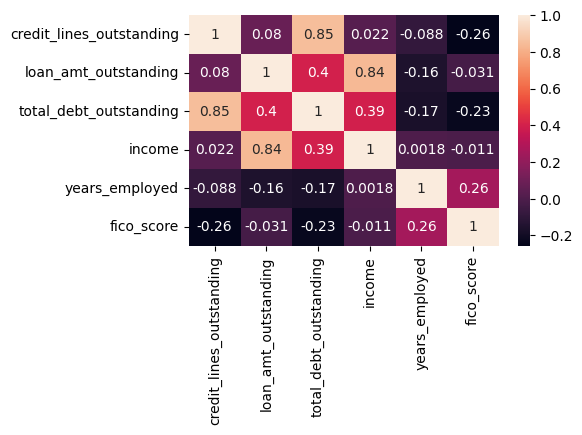

In [54]:
num_vars = ['credit_lines_outstanding', 'loan_amt_outstanding', 'total_debt_outstanding', 'income', 'years_employed', 'fico_score']
# Correlation matrix
corr_matrix = df[num_vars].corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

Variance Inflation Factor (VIF):

It provides an index that measures how much the variance of an estimated regression coefficient is increased because of multicollinearity.

Interpretation:
VIF = 1 (Not correlated)
1 < VIF < 5 (Moderately correlated)
VIF >= 5 (Highly correlated)
3. Eigenvalues:

When performing principal component analysis (PCA) or factor analysis, small eigenvalues indicate the presence of multicollinearity.
4. Condition Index:

Calculated as the square root of the ratio of the largest eigenvalue to each individual eigenvalue.
A condition index above 30 indicates multicollinearity.
5. Pair Plots or Scatter Plots:

Visual inspection of all scatter plots among independent variables.
6. Tolerance:

Tolerance is the reciprocal of the VIF.
The smaller the tolerance, the higher the multicollinearity.

In [ ]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming `df` is your data and `features` is a list of your feature column names.
X = df[num_vars]

# Adding a constant to the model is optional.
X['Intercept'] = 1

# Calculating VIF for each feature.
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


                   Variable         VIF
0  credit_lines_outstanding    6.834789
1      loan_amt_outstanding    3.669034
2    total_debt_outstanding    8.178109
3                    income    4.724246
4            years_employed    1.259846
5                fico_score    1.144339
6                 Intercept  140.045889


<ipython-input-20-70f1bfd5ebf3>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Intercept'] = 1


It seems both from heat map plot and VIF indcates credit_lines_outstanding and total_debt_outstanding are corelated. We will keep in mind but lets move ahead and will see later if removing one of the variable or applying PCA tranformation can help.

#

In [ ]:
# Train-test split
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_df, test_df =  train_test_split(df, test_size=0.20, random_state=100, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=0.20, random_state=100, shuffle=True )

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, recall_score, f1_score,confusion_matrix, classification_report
def evaluate_metrics(y_test,y_pred):
    # Evaluate the performance of the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    #classification = classification_report(y_test, y_pred)
    print("Accuracy:  {:.3f}".format(accuracy))
    print("Precision: {:.3f}".format(precision))
    print("Recall: {:.3f}".format(recall))
    print("F1 Score: {:.3f}".format( f1))
    print("ROC : {:.3f}".format(roc))
    #print("Classification_report :")
    #print(classification)
    #return(accuracy,precision,recall,f1,roc,classification)
    return(accuracy,precision,recall,f1,roc)

# plot the confusion matrix as a heatmap
def Plot_confusion_matrix(y_test, y_pred):
  plt.figure(figsize=(3,3))
  cm = confusion_matrix(y_test, y_pred)
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent)
  sns.heatmap(cm, annot=True, cmap="Blues", fmt='g')
  classNames = ['NonFraud','Fraud']
  plt.title('Confusion Matrix ')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  tick_marks = np.arange(len(classNames))
  plt.xticks(tick_marks, classNames, rotation=0,ha='left')
  plt.yticks(tick_marks, classNames,rotation=90, ha='left')
  s = [['TN','FP'], ['FN', 'TP']]
  plt.show()
  #for i in range(2):
  #    for j in range(2):
  #        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),fontsize=12)
  #plt.show()
def impfeatures(model):
    plt.figure(figsize=(6,3))
    fimp = model.feature_importances_
    indices = np.argsort(fimp)[::-1]
    sorted_features = np.array([Xval[i] for i in range(len(Xval))])[indices]

    #plot sorted feature importance
    plt.bar(sorted_features, fimp[indices])
    plt.xticks(rotation=90)
    plt.xlabel('Features')
    plt.ylabel('Importance Score')
    plt.title('Feature Importance')
    plt.show()




In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
#from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
df_metric = pd.DataFrame(columns=['modelname','acc', 'prec', 'recall', 'f1', 'roc'])
models = {
    "Decision Tree" : DecisionTreeClassifier(),
    "Random Forest" : RandomForestClassifier(),
    "LogisticRegression" : LogisticRegression(max_iter =1000),
    #"Support Vector Machhine" : SVC(),
    "k-Nearest Neighbour "    :  KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBClassifier": XGBClassifier(),
    "AdaBoost Classifier": AdaBoostClassifier(),
    #"CatBoosting Classifier": CatBoostClassifier(verbose=False)
}

Model Performance for the  Decision Tree
Accuracy:  0.996
Precision: 0.993
Recall: 0.987
F1 Score: 0.990
ROC : 0.993


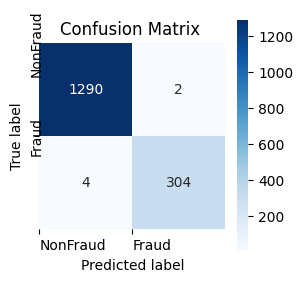

---------------------------------------
Model Performance for the  Random Forest
Accuracy:  0.997
Precision: 0.993
Recall: 0.990
F1 Score: 0.992
ROC : 0.994


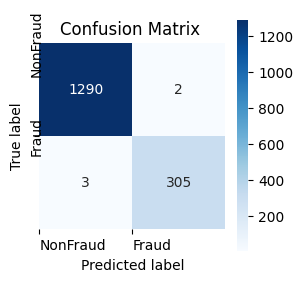

---------------------------------------
Model Performance for the  LogisticRegression
Accuracy:  0.999
Precision: 1.000
Recall: 0.997
F1 Score: 0.998
ROC : 0.998


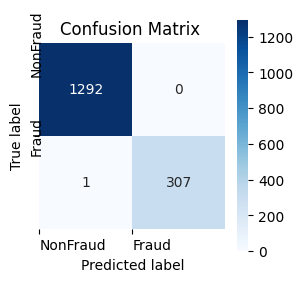

---------------------------------------
Model Performance for the  k-Nearest Neighbour 
Accuracy:  0.981
Precision: 0.954
Recall: 0.945
F1 Score: 0.949
ROC : 0.967


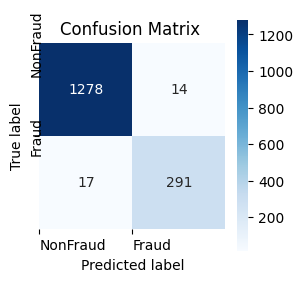

---------------------------------------
Model Performance for the  Gradient Boosting
Accuracy:  0.997
Precision: 0.990
Recall: 0.994
F1 Score: 0.992
ROC : 0.996


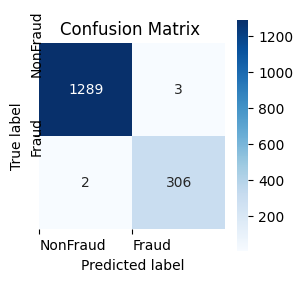

---------------------------------------
Model Performance for the  XGBClassifier
Accuracy:  0.996
Precision: 0.990
Recall: 0.990
F1 Score: 0.990
ROC : 0.994


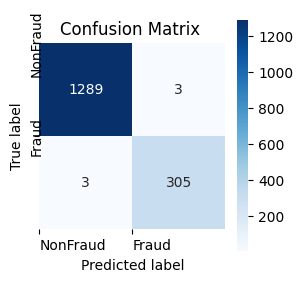

---------------------------------------
Model Performance for the  AdaBoost Classifier
Accuracy:  0.996
Precision: 0.987
Recall: 0.994
F1 Score: 0.990
ROC : 0.995


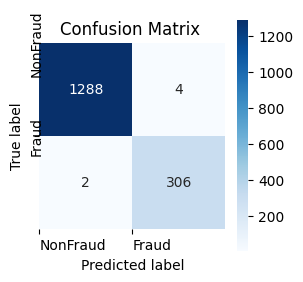

---------------------------------------


In [ ]:
Xval = ['credit_lines_outstanding', 'loan_amt_outstanding', 'total_debt_outstanding', 'income', 'years_employed', 'fico_score']
target =['default']
for i in range(len(list(models))):
    model =list(models.values())[i]
    model.fit(train_df[Xval],train_df[target].values.ravel())
    y_pred_model = model.predict(valid_df[Xval])
    y_test_model = valid_df[target]

    print("Model Performance for the ",list(models.keys())[i])
    acc,prec,recall,f1,roc = evaluate_metrics(y_test_model,y_pred_model)
    row = {'modelname' : list(models.keys())[i], 'acc': acc, 'prec': prec, 'recall': recall, 'f1': f1, 'roc': roc}
    df_metric = pd.concat([df_metric, pd.DataFrame([row])], ignore_index=True)
    #df_metric= df_metric.append(row,ignore_index=True)
    #impfeatures(model)
    Plot_confusion_matrix(y_test_model,y_pred_model)
    print("---------------------------------------")


In [ ]:
df_metric

,modelname,acc,prec,recall,f1,roc
0,Decision Tree,0.996250,0.993464,0.987013,0.990228,0.992732
1,Random Forest,0.996875,0.993485,0.990260,0.991870,0.994356
2,LogisticRegression,0.999375,1.000000,0.996753,0.998374,0.998377
3,k-Nearest Neighbour,0.980625,0.954098,0.944805,0.949429,0.966985
4,Gradient Boosting,0.996875,0.990291,0.993506,0.991896,0.995592
5,XGBClassifier,0.996250,0.990260,0.990260,0.990260,0.993969
6,AdaBoost Classifier,0.996250,0.987097,0.993506,0.990291,0.995205


Seems logistic regression work the best so to move ahead will continue with Logistic regreesion. The next step would be to calculate the probability of Default (PD) which will be outcome our model. Our final goal is to calculate the Expected Loss which be a procuct of  PD , 1-recovery rate and outstanding loan left



In [ ]:
def evaluate_model_and_calculate_EL(model, X, EAD, recovery_rate=0.10):
    """
    Evaluate model and calculate Expected Loss.

    Parameters:
        model : Trained logistic regression model
        X : Features for prediction, shape (n_samples, n_features)
        y_true : True labels, shape (n_samples,)
        EAD : Exposure at Default, float or array-like of shape (n_samples,)
        recovery_rate : Recovery rate, float, optional (default=0.10)

    Returns:
        PD : Probability of Default, array of shape (n_samples,)
        EL : Expected Loss, array of shape (n_samples,)
        ... (any other evaluation metric or result)
    """
    # Predicting PD
    PD = model.predict_proba(X)[:, 1]

    # Calculating LGD
    LGD = 1 - recovery_rate

    # Calculating EL
    EL = PD * LGD * EAD

    # Evaluating the Model
    # (insert model evaluation using PD and y_true, e.g., ROC AUC, log loss, etc.)

    return PD, EL


In [ ]:
model = LogisticRegression(max_iter = 1000)
model.fit(df[Xval],df[target].values.ravel())
X_new = train_df[Xval]
EAD = train_df['loan_amt_outstanding']
PD,EL = evaluate_model_and_calculate_EL(model, X_new, EAD, recovery_rate=0.10)

print(list(PD))
print(list(EL))



[2.283945408693079e-05, 6.687634755932691e-09, 0.994472732655398, 7.415561286475142e-14, 1.446584521842973e-09, 6.808545414849458e-10, 1.6606835165267538e-08, 0.9687102250706228, 7.3254009935679855e-06, 5.4658280229702005e-06, 1.3856858173808176e-07, 0.4600351795926036, 0.9999980074320192, 0.9999998426875721, 6.692076154459224e-06, 1.2608655427162742e-06, 9.242639094324616e-07, 0.08852923663801333, 0.2930674607154602, 6.31038855070137e-06, 0.006452750119175107, 2.417089971248875e-06, 5.927538183300886e-08, 0.1340207470548556, 9.980939165717119e-07, 1.3334855083609978e-07, 0.03102218746301823, 0.013432267779089737, 4.220117689535821e-06, 8.834119259595393e-07, 2.423316335574592e-08, 1.8554702255952843e-11, 3.1199656150760526e-06, 3.626062192174407e-11, 0.00037200052862560633, 2.3987763325078845e-07, 0.014717872729088548, 0.9999829232077784, 1.9545417184870153e-07, 1.1599076153218922e-13, 0.9999938653591597, 0.0017019284772445587, 0.9999999740502632, 3.4214716293642516e-07, 5.27331248280